# 1. Data Acquisition and Initial Notebook Setup

Data was retrieved from NCBI's GEO database. This data was sourced from a GEO entry by TJ Schulz and M Leer (no associated publication) (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE247313). The dataset is described by the authors as a transcriptional data that can bne used to "analyze the cellular heterogeneity of mononucleated, non-myofiber cell populations and their transcriptional states in post-injury skeletal muscle". 

This notebook is concerned with the data analysis of aged samples.

In [ ]:
#install and import the immediately necessary libraries
!pip install numpy
!pip install pandas
!pip install scanpy
!pip install matplotlib
!pip install seaborn

import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **'2. Loading/Reading Data' and 'Doublet Removal' steps can be skipped, as this requires training a model for doublet detection, which can be time consuming and requires considerable compute power. I have filtered the AnnData object and written it to a new file in the 'doublet_filtered' folder in the 'data' folder. Skip to "Read in doublet filtered data"**

---

# 2. Loading/Reading Data 

In [ ]:
#importing data for old, post-injury skeletal muscle samples, adjust for your directory
adata = sc.read_mtx('data/raw_data/GSE247313_RAW/GSM7887084_B4_matrix.mtx.gz').T
adata.var_names = pd.read_csv('data/raw_data/GSE247313_RAW/GSM7887084_B4_features.tsv.gz', header = None)[0]
adata.obs_names = pd.read_csv('data/raw_data/GSE247313_RAW/GSM7887084_B4_barcodes.tsv.gz', header = None)[0]

adata

# 3. Quality Control

I am looking to remove low quality reads from the dataset. I will be aiming to remove cells with low number of detected genes, low count depth, and high fraction of mitochondrial counts. Barcodes with these characteritics may indicate dead, non-viable cells (ex. cells with broken membranes), empty droplets or doublets.

I will be starting with doublet removal

### Doublet removal

In [ ]:
import scvi 

sc.pp.filter_genes(adata, min_cells = 10)
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

In [ ]:
doub_df = solo.predict()
doub_df['prediction'] = solo.predict(soft = False)

#doub_df.index = doub_df.index.map(lambda x: x[:-2])

doub_df

In [ ]:
doub_df.groupby('prediction').count()

In [ ]:
doub_df['dif'] = doub_df.doublet - doub_df.singlet

sns.displot(doub_df[doub_df.prediction == 'doublet'], x = 'dif')

In [ ]:
doublets = doub_df[(doub_df.prediction == 'doublet') & (doub_df.dif > 1)]
doublets

In [ ]:
adata = sc.read_mtx('GSE247313_RAW/GSM7887084_B4_matrix.mtx.gz').T
adata.var_names = pd.read_csv('/Users/danielpintard/Documents/Code/Bioinformatics/Learning_Bioinformatics/learningscRNAseq/GSE247313_RAW/GSM7887083_B4_features.tsv', header = None)[0]
adata.obs_names = pd.read_csv('GSE247313_RAW/GSM7887084_B4_barcodes.tsv.gz', header = None)[0]

In [ ]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [ ]:
adata_filtered = adata[~adata.obs.doublet]


In [ ]:
adata_filtered

In [ ]:
adata_filtered.write('old_filtered_adata.h5ad')

---

## **Read in doublet filtered data**

You can skip to here to read in the doublet filtered AnnData object.

In [2]:
adata = sc.read_h5ad('/Users/danielpintard/Documents/Code/Bioinformatics/scRNAseq-SCAMPs/data/doublet_filtered/old_filtered_adata.h5ad') #change path to suit your directories

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Continued Preprocessing

Eliminating low quality reads (ex non viable cells, empty droplets)

In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")

adata

AnnData object with n_obs × n_vars = 6421 × 32285
    obs: 'doublet'
    var: 'mt'

In [4]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

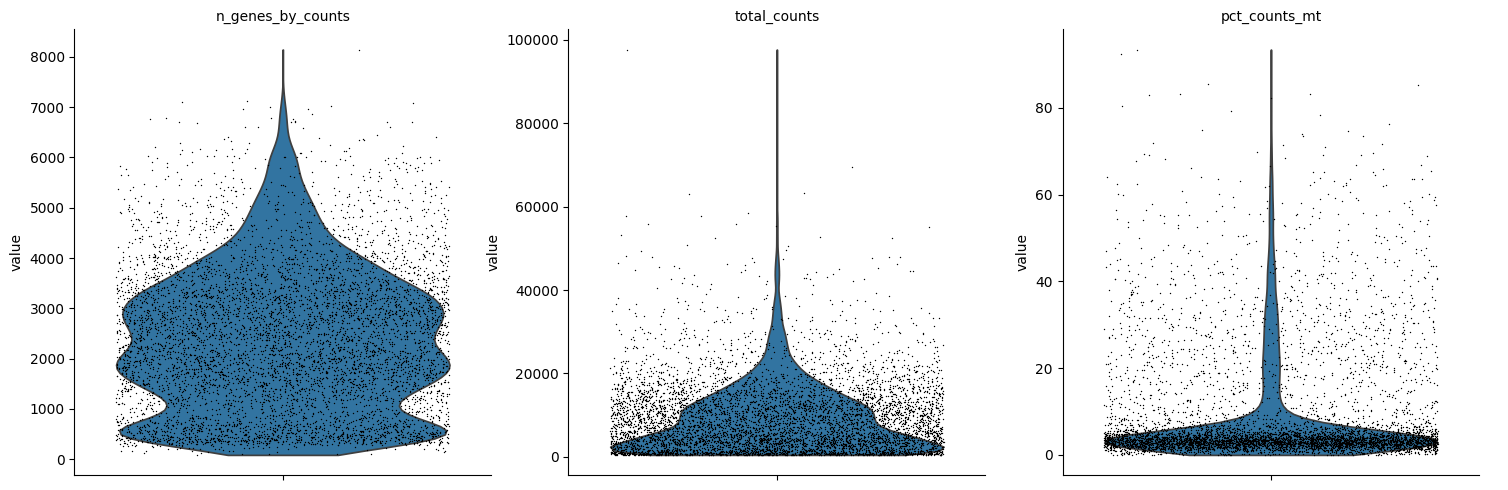

In [8]:
adata.var_names_make_unique()
#sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True) #plotting for wrangling and thresholding

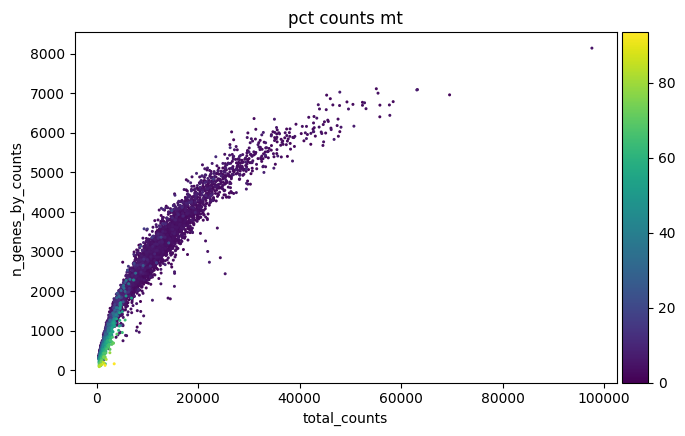

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color = "pct_counts_mt") # plotting for EDA

In [10]:
adata = adata[adata.obs['pct_counts_mt'] <= 80] #filtering out cells with percent of genes from mitochondrial data > 80% since these cells are most likely non viable

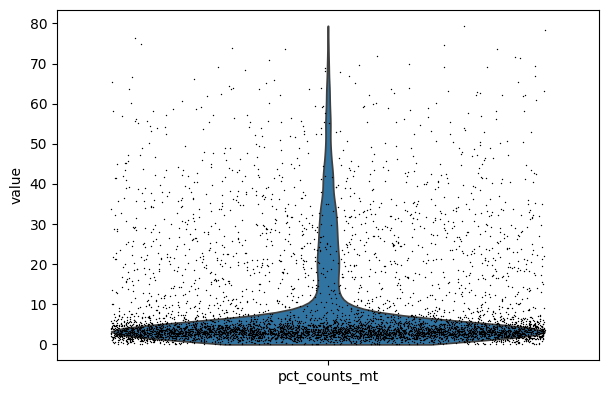

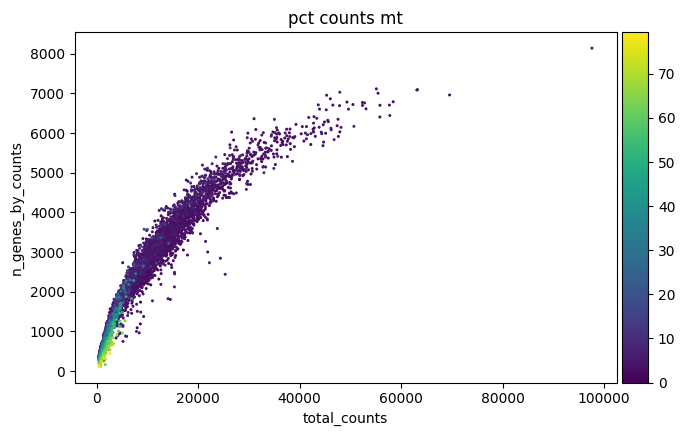

In [11]:
#not necessary
sc.pl.violin(adata, ["pct_counts_mt"], jitter=0.4)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color = "pct_counts_mt")
# plotting for visualization

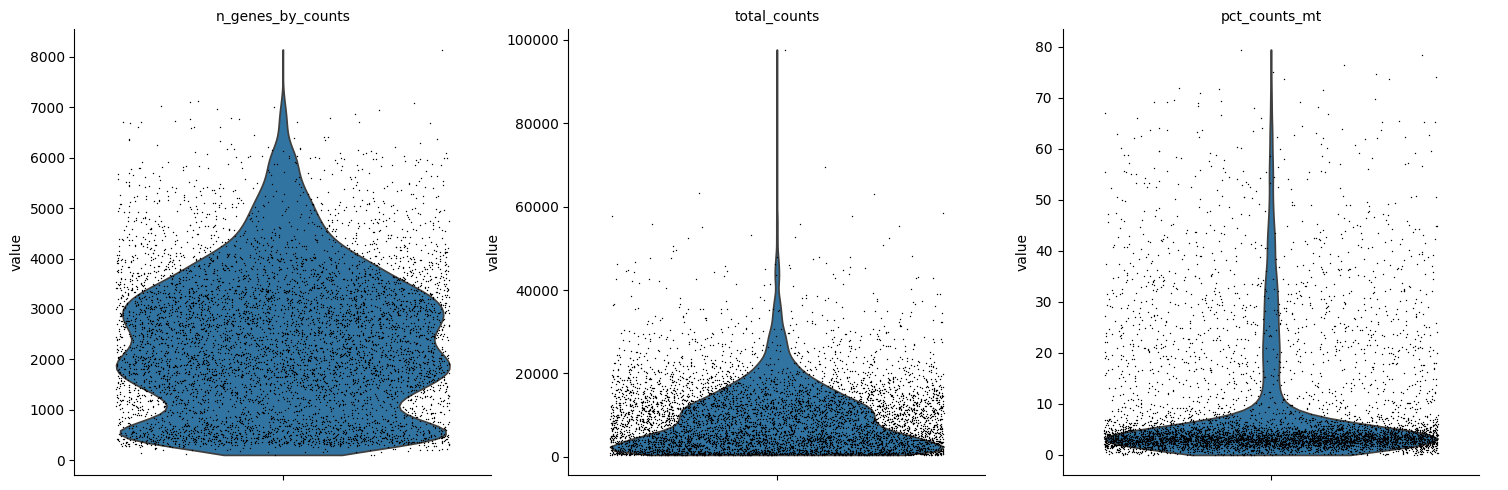

In [12]:
# not necessary 
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
# plotting for exploratory analysis

In [13]:
adata.obs #viewing qc metrics, not necessary 

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGAGGCGTT-1    False                532        1103.0            277.0   
AAACCCAAGGTTTACC-1    False               6782       49327.0           1225.0   
AAACCCAAGTCACACT-1    False               1476        3256.0             84.0   
AAACCCACAACACACT-1    False                692        1579.0            554.0   
AAACCCACACTCTAGA-1    False               1239        2375.0             67.0   
...                     ...                ...           ...              ...   
TTTGTTGAGAGGCCAT-1    False               3355       17045.0            591.0   
TTTGTTGAGCATTTCG-1    False                927        1457.0            124.0   
TTTGTTGGTAACATGA-1    False               3424       14923.0            274.0   
TTTGTTGTCAGCGGAA-1    False                908        2552.0            742.0   
TTTGTTGTCGCTGATA-1    False               3442       15817.0            337.0   

                    pct_counts_mt  
AAACCCAAGAGGCGTT-1      25.113327  
AAACCCAAGGTTTACC-1       2.483427  
AAACCCAAGTCACACT-1       2.579853  
AAACCCACAACACACT-1      35.085495  
AAACCCACACTCTAGA-1       2.821053  
...                           ...  
TTTGTTGAGAGGCCAT-1       3.467292  
TTTGTTGAGCATTTCG-1       8.510638  
TTTGTTGGTAACATGA-1       1.836092  
TTTGTTGTCAGCGGAA-1      29.075235  
TTTGTTGTCGCTGATA-1       2.130619  

[6412 rows x 5 columns]

In [14]:
adata #clean data, filtered out doublets and outliers 

View of AnnData object with n_obs × n_vars = 6412 × 32285
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# 4. Normalization

In [15]:
adata.X.sum(axis = 1)

matrix([[ 1103.],
        [49327.],
        [ 3256.],
        ...,
        [14923.],
        [ 2552.],
        [15817.]], dtype=float32)

In [16]:
sc.pp.normalize_total(adata, target_sum = 1e4) # normalize every cell to 10,000 unique cells (Counts per Million)

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
adata.X.sum(axis = 1) #view after normalization

matrix([[10000.03 ],
        [10000.046],
        [10000.053],
        ...,
        [ 9999.907],
        [ 9999.971],
        [10000.033]], dtype=float32)

In [18]:
sc.pp.log1p(adata) #log transformation

In [19]:
adata.X.sum(axis = 1)

matrix([[1358.5659],
        [3977.3784],
        [2571.3296],
        ...,
        [3203.9944],
        [1688.5938],
        [3174.7256]], dtype=float32)

In [20]:
adata.raw = adata #saving already preprocessed data into raw slot of AnnData object

# 5. Feature Selection and Dimension Reductionality 

In [21]:
adata.var #viewing genes

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Xkr4        False                 13     0.002180              99.797539   
Gm1992      False                  0     0.000000             100.000000   
Gm19938     False                 11     0.002025              99.828687   
Gm37381     False                  0     0.000000             100.000000   
Rp1         False                  0     0.000000             100.000000   
...           ...                ...          ...                    ...   
AC124606.1  False                  0     0.000000             100.000000   
AC133095.2  False                  0     0.000000             100.000000   
AC133095.1  False                  0     0.000000             100.000000   
AC234645.1  False                  0     0.000000             100.000000   
AC149090.1  False               1924     0.462078              70.035820   

            total_counts  
Xkr4                14.0  
Gm1992               0.0  
Gm19938             13.0  
Gm37381              0.0  
Rp1                  0.0  
...                  ...  
AC124606.1           0.0  
AC133095.2           0.0  
AC133095.1           0.0  
AC234645.1           0.0  
AC149090.1        2967.0  

[32285 rows x 5 columns]

In [22]:
sc.pp.highly_variable_genes(adata, n_top_genes = 30000) #tenfold dimension reduction + feature selction (selecting for genes that are highly variable)

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [23]:
adata = adata[:, adata.var.highly_variable]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 6412 × 32285
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [25]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:644: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [26]:
sc.pp.scale(adata, max_value = 10)

In [27]:
sc.tl.pca(adata, svd_solver = 'arpack') #Principle Component Analysis for Dimension Reductionality 

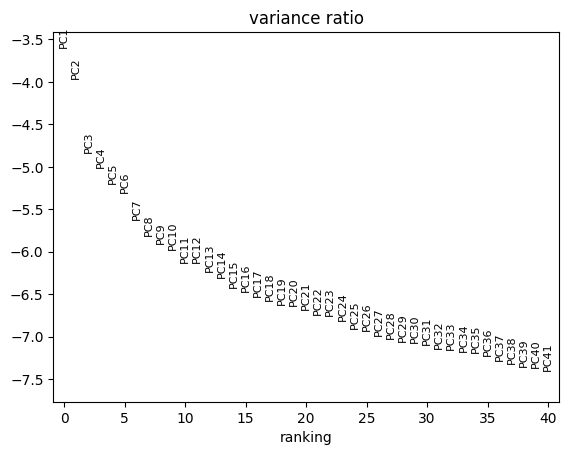

In [28]:
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 40)

# 6. Clustering 

In [29]:
sc.pp.neighbors(adata, n_pcs = 12) 

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
sc.tl.umap(adata)

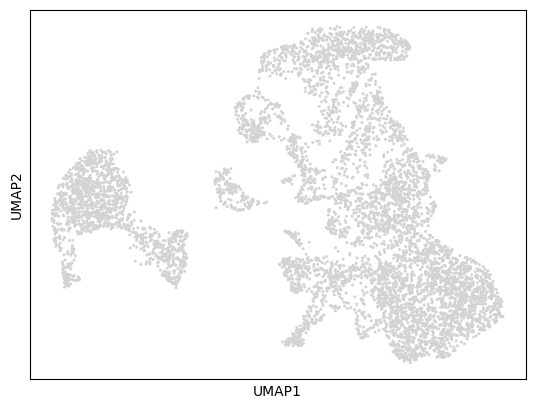

In [31]:
sc.pl.umap(adata)

In [32]:
sc.tl.leiden(adata, resolution = 0.2)

/var/folders/vz/ggcbdp195vb6bwjd2hw6yfsc0000gn/T/ipykernel_7762/3864225830.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.2)


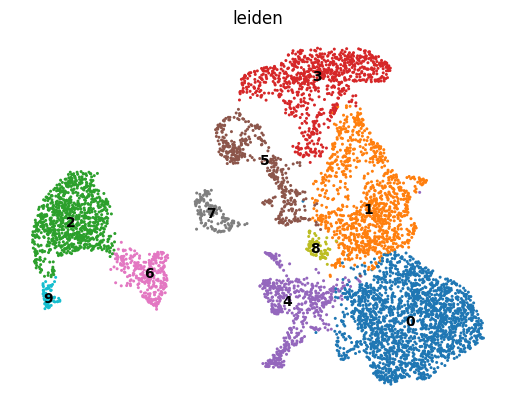

In [33]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = 'on data')

# 7. Finding Marker Genes/Cell Type Labelling 

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden')

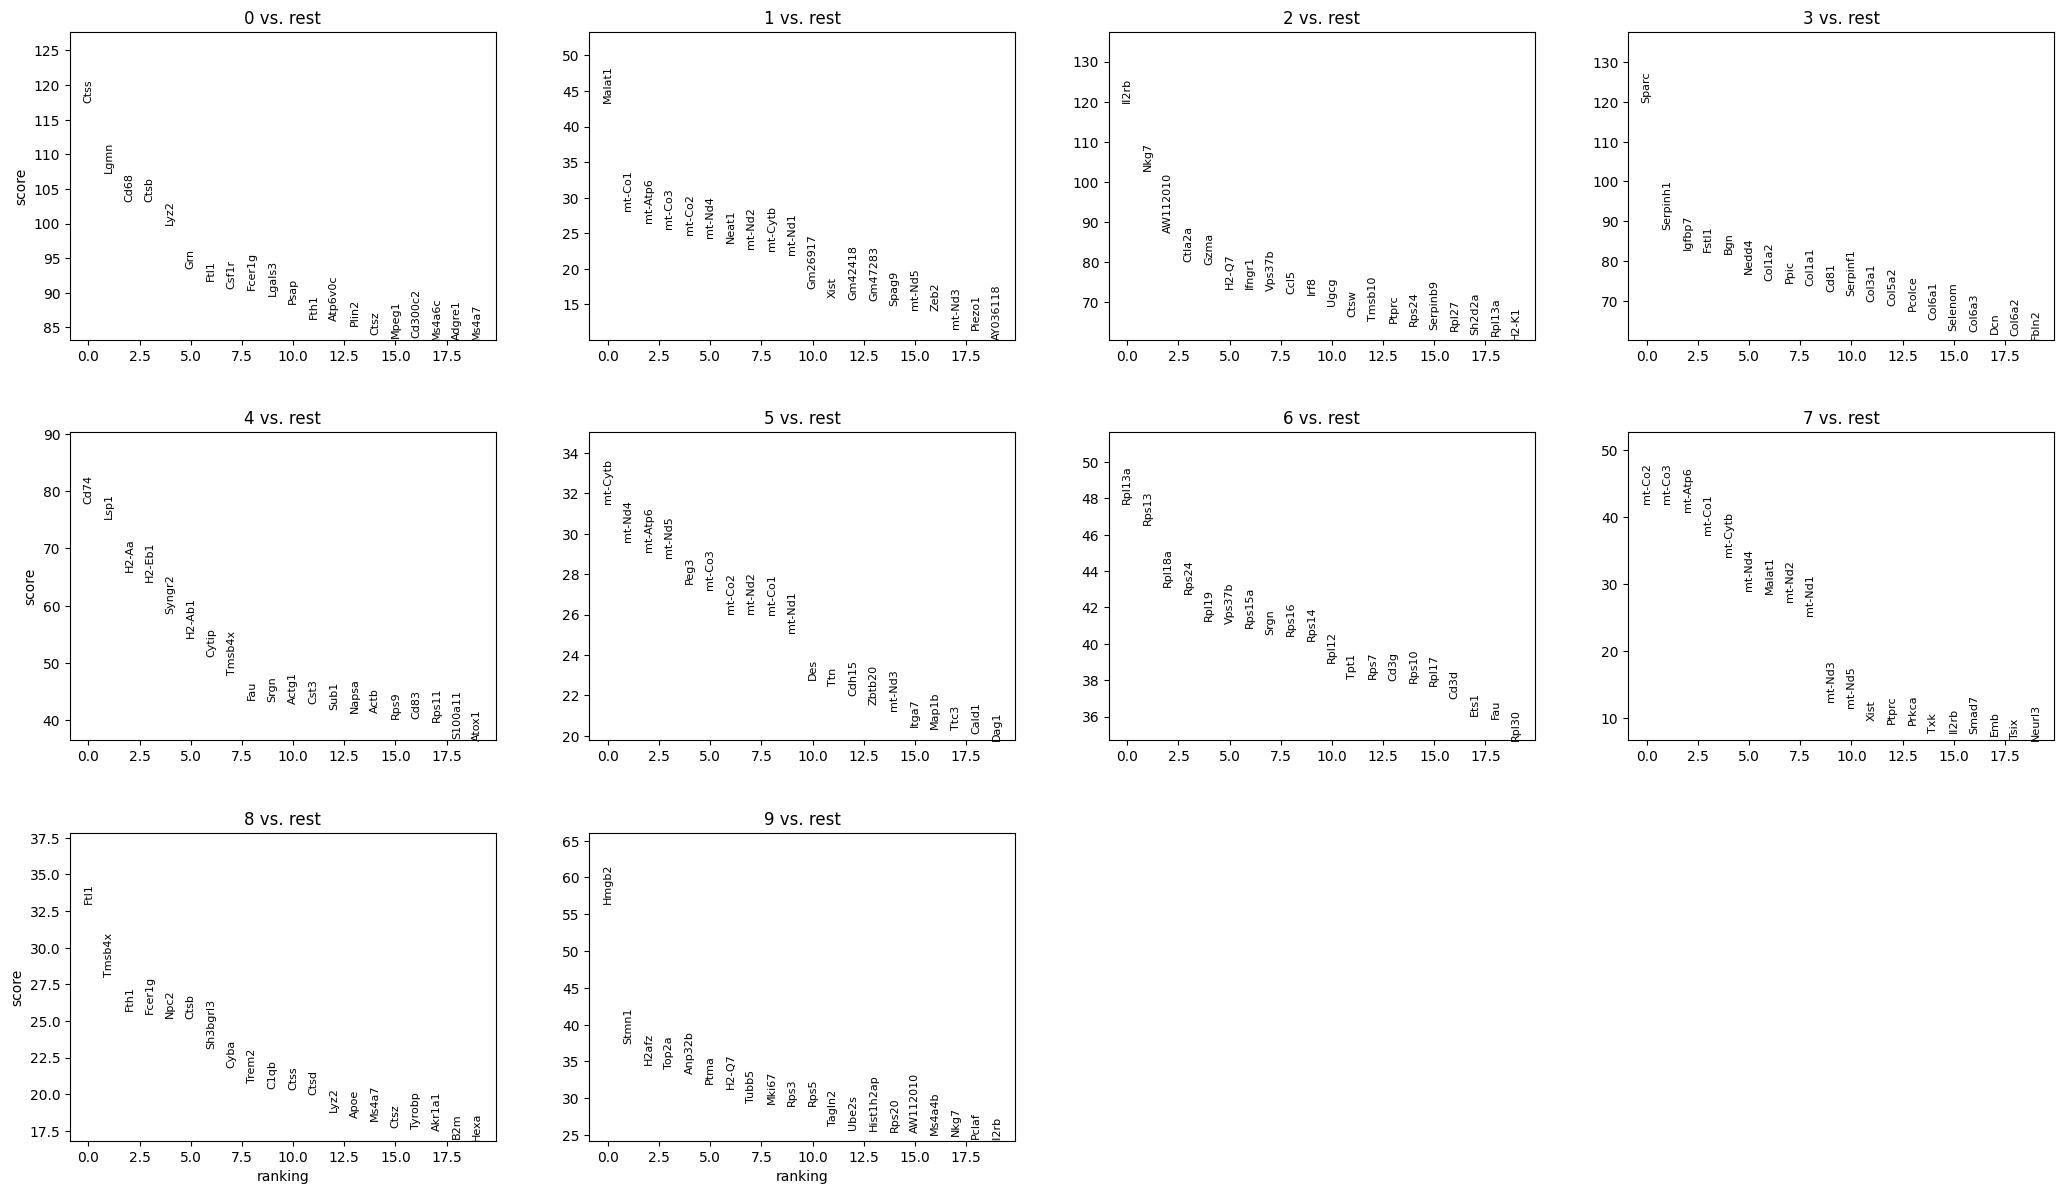

In [35]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In [36]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

group          names      scores  logfoldchanges     pvals  pvals_adj
0          0           Ctss  117.409126        4.794005  0.000000   0.000000
1          0           Lgmn  107.386414        4.170425  0.000000   0.000000
2          0           Cd68  103.211220        4.629119  0.000000   0.000000
3          0           Ctsb  103.132378        4.169779  0.000000   0.000000
4          0           Lyz2   99.776253        5.006589  0.000000   0.000000
...      ...            ...         ...             ...       ...        ...
293393     9  A930005H10Rik    2.513442        1.551020  0.014300   0.049792
293394     9        Cd200r4    2.512587        1.607815  0.014337   0.049897
293395     9          Grwd1    2.512174        1.685022  0.014358   0.049946
293396     9         Vps13b    2.511313        0.910262  0.014352   0.049935
293397     9         Sorbs1    2.510974        1.531117  0.014376   0.049986

[24674 rows x 6 columns]

---

### This is gene marker identification. I did this manually (4 times), so this part can be skipped since the clusters have already been identified

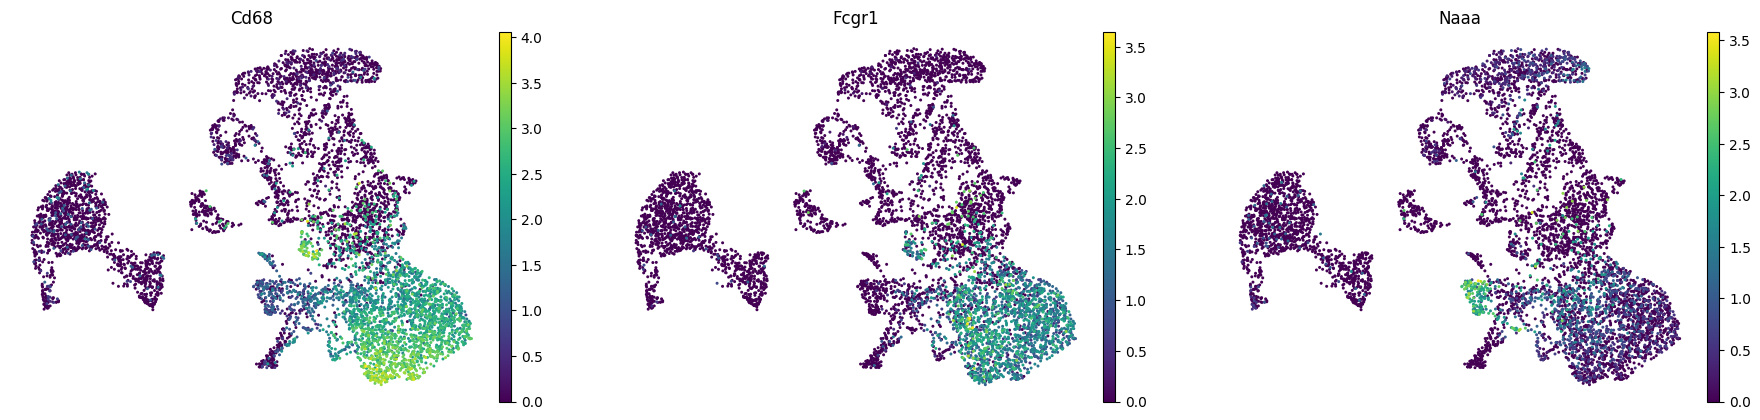

In [37]:
#Identifying cluster 0 
sc.pl.umap(adata, color = ['Cd68', 'Fcgr1', 'Naaa'], frameon = False)

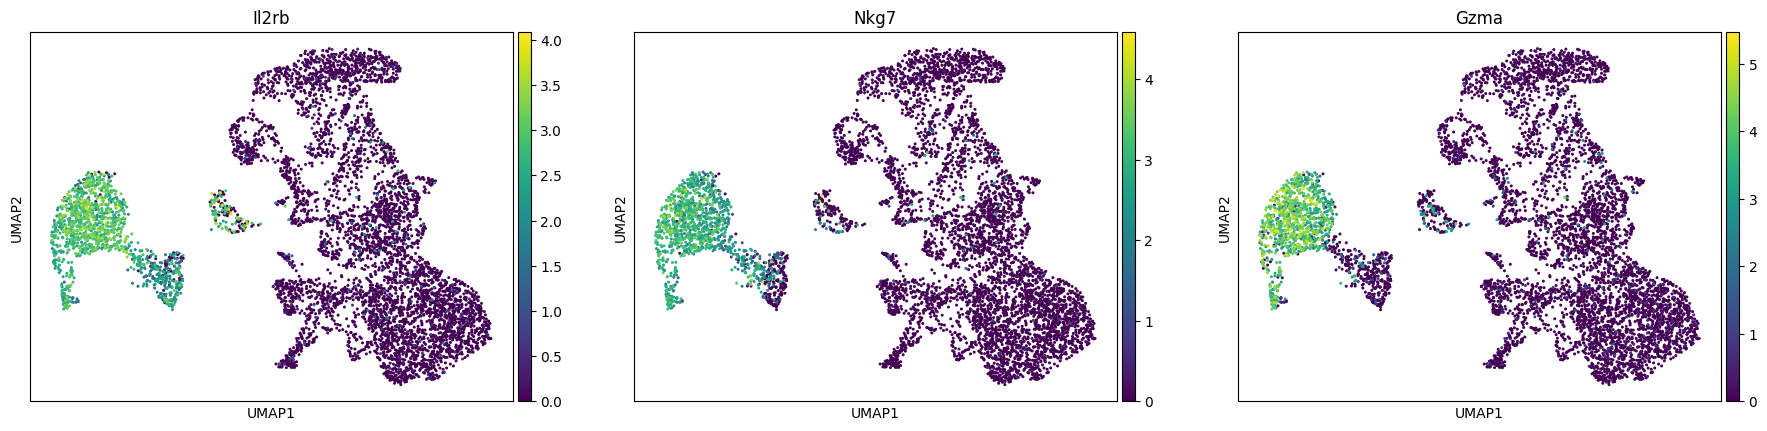

In [38]:
#Id cluster 2 and 9 
sc.pl.umap(adata, color = ['Il2rb', 'Nkg7', 'Gzma'])

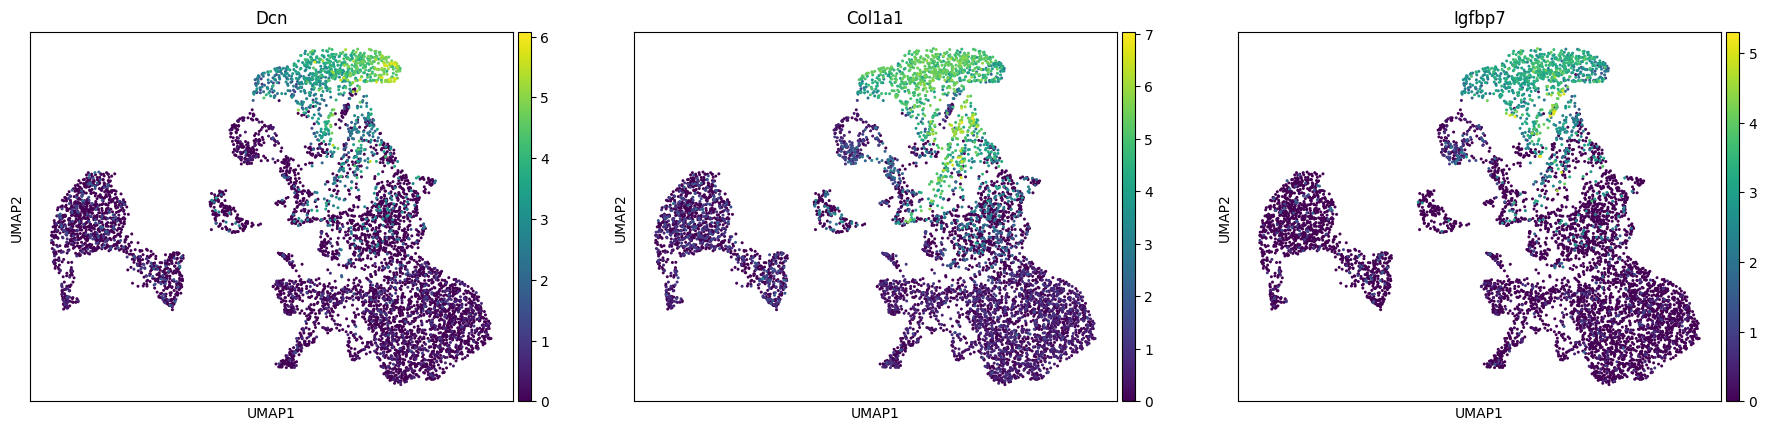

In [39]:
#Id cluster 3 and 1
sc.pl.umap(adata, color = ['Dcn', 'Col1a1', 'Igfbp7'])

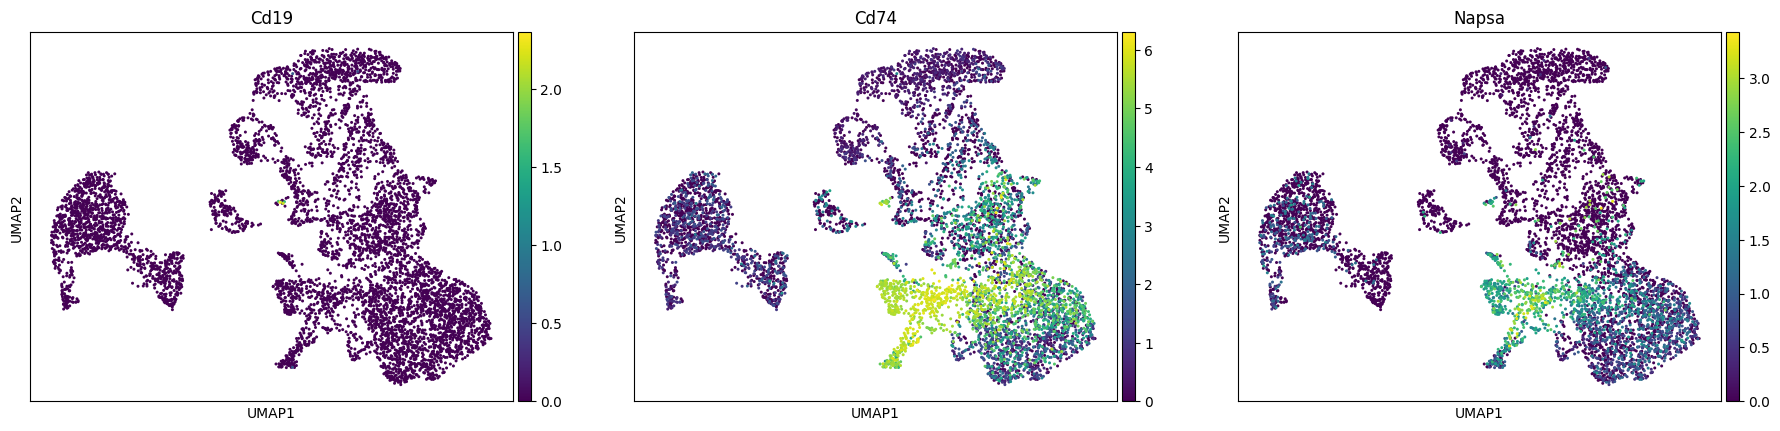

In [40]:
sc.pl.umap(adata, color = ['Cd19', 'Cd74', 'Napsa'])

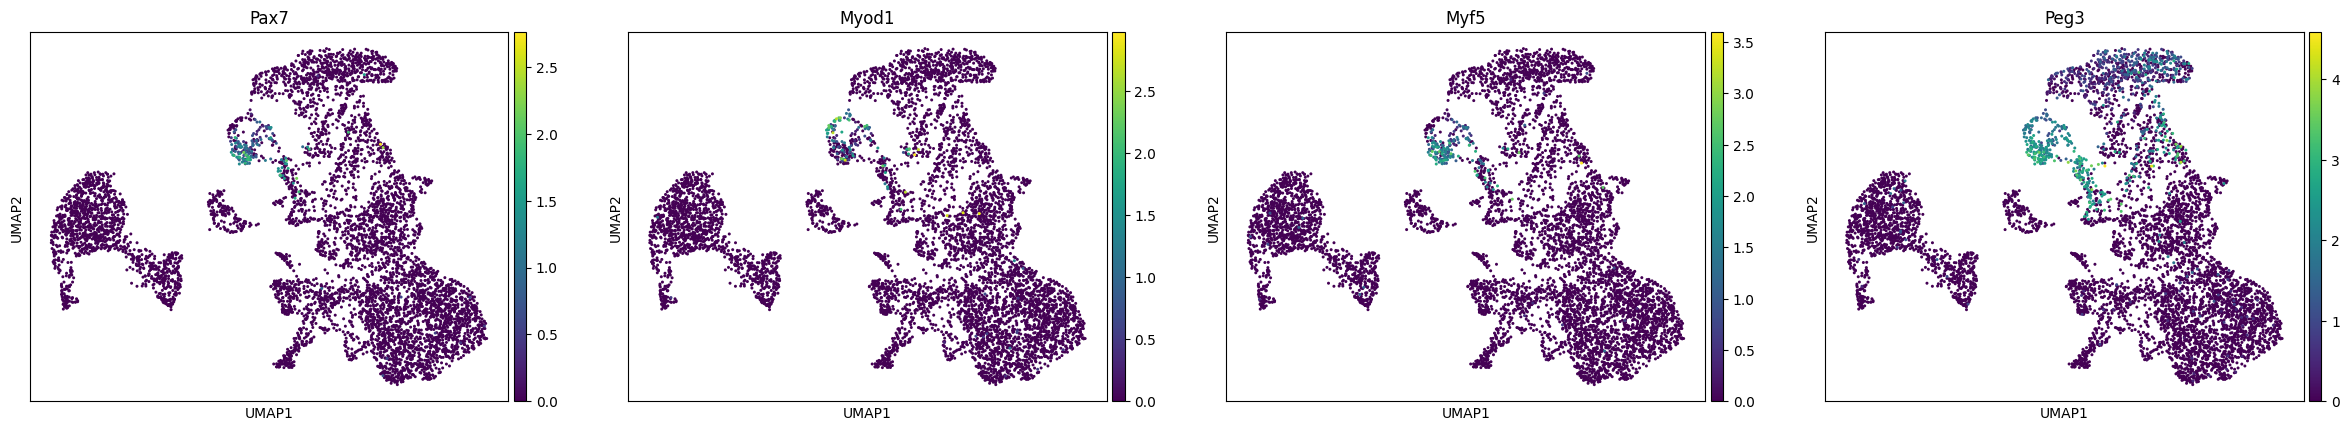

In [41]:
sc.pl.umap(adata, color = ['Pax7', 'Myod1', 'Myf5', 'Peg3'])

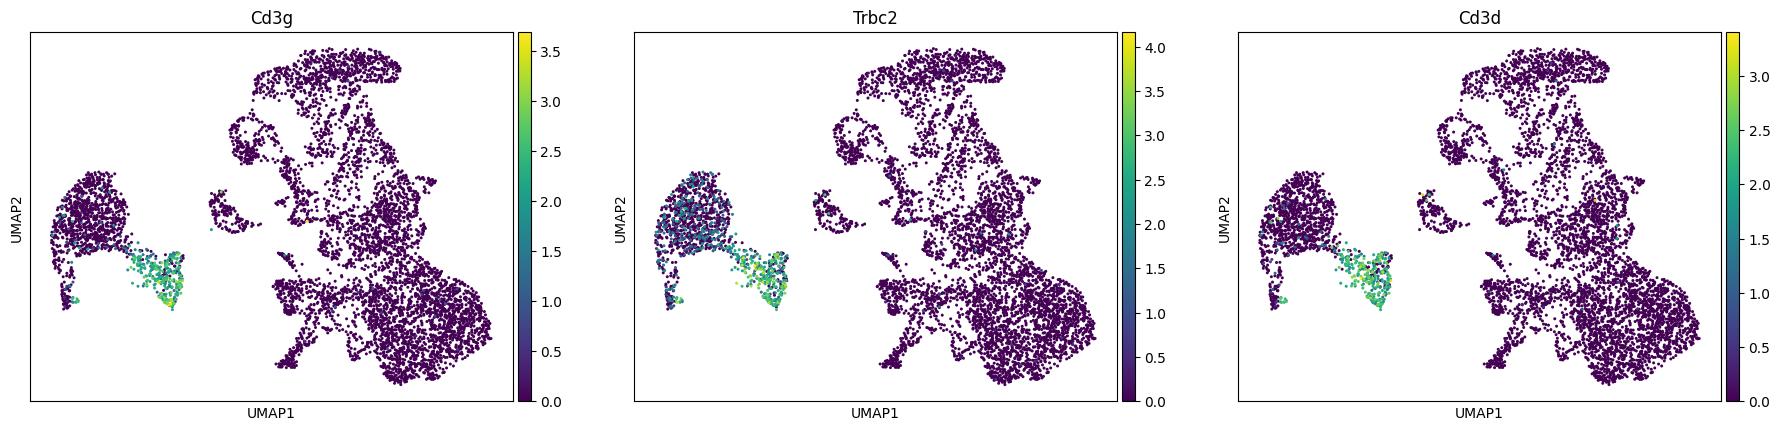

In [42]:
sc.pl.umap(adata, color = ['Cd3g', 'Trbc2', 'Cd3d'])

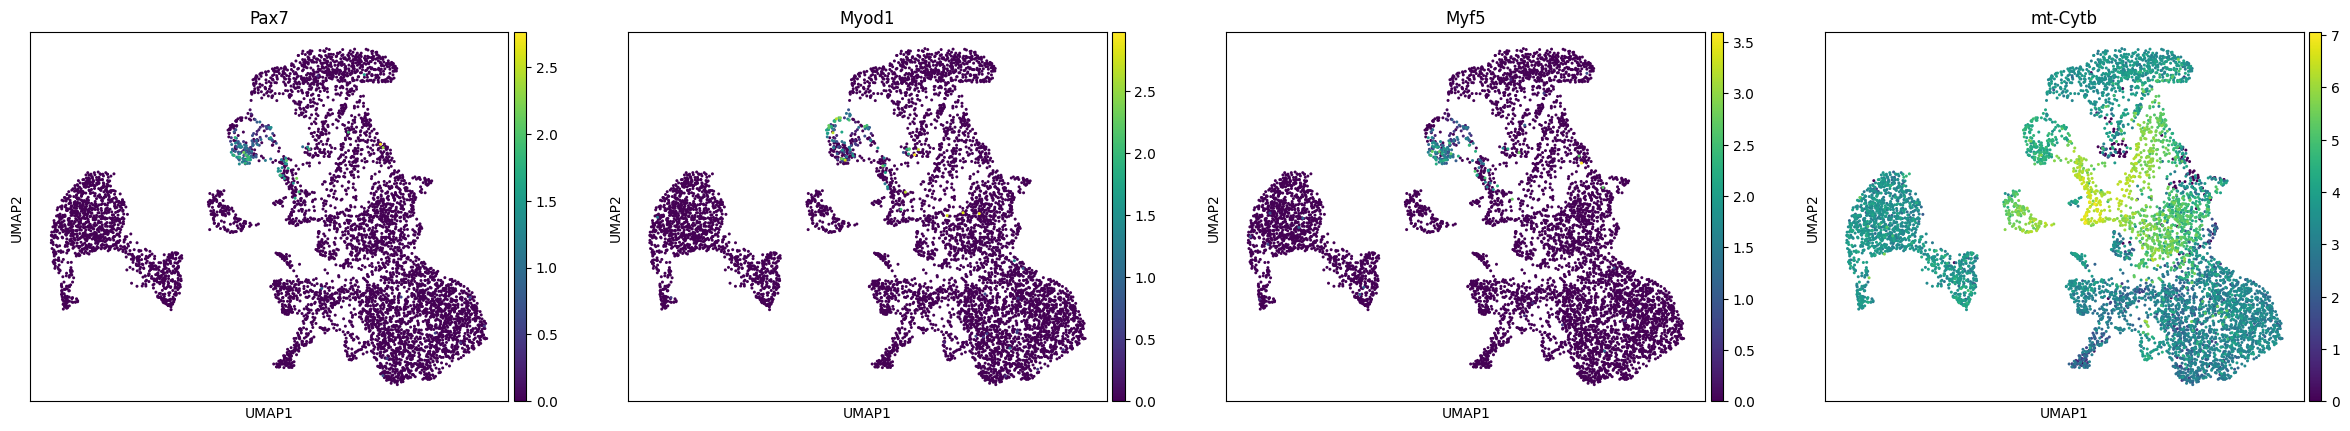

In [43]:
sc.pl.umap(adata, color = ['Pax7', 'Myod1', 'Myf5', 'mt-Cytb'])

---

### You can pick up here, where the leiden clusters are identified with their cell types

In [44]:
cell_types = {
    '0' : 'Macrophages',
    '1' : 'Fibroblasts/FAP',
    '2' : 'Nk cell',
    '3' : 'Fibroblasts/FAP',
    '4' : 'Macrophages',
    '5' : 'Satellite cells',
    '6' : 'T cells',
    '7' : 'Unknown',
    '8' : 'Macrophages',
    '9' : 'Nk cells',
}

In [45]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_types)

In [46]:
adata.obs

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGAGGCGTT-1    False                532        1103.0            277.0   
AAACCCAAGGTTTACC-1    False               6782       49327.0           1225.0   
AAACCCAAGTCACACT-1    False               1476        3256.0             84.0   
AAACCCACAACACACT-1    False                692        1579.0            554.0   
AAACCCACACTCTAGA-1    False               1239        2375.0             67.0   
...                     ...                ...           ...              ...   
TTTGTTGAGAGGCCAT-1    False               3355       17045.0            591.0   
TTTGTTGAGCATTTCG-1    False                927        1457.0            124.0   
TTTGTTGGTAACATGA-1    False               3424       14923.0            274.0   
TTTGTTGTCAGCGGAA-1    False                908        2552.0            742.0   
TTTGTTGTCGCTGATA-1    False               3442       15817.0            337.0   

                    pct_counts_mt leiden        cell type  
AAACCCAAGAGGCGTT-1      25.113327      1  Fibroblasts/FAP  
AAACCCAAGGTTTACC-1       2.483427      5  Satellite cells  
AAACCCAAGTCACACT-1       2.579853      2          Nk cell  
AAACCCACAACACACT-1      35.085495      1  Fibroblasts/FAP  
AAACCCACACTCTAGA-1       2.821053      2          Nk cell  
...                           ...    ...              ...  
TTTGTTGAGAGGCCAT-1       3.467292      4      Macrophages  
TTTGTTGAGCATTTCG-1       8.510638      1  Fibroblasts/FAP  
TTTGTTGGTAACATGA-1       1.836092      4      Macrophages  
TTTGTTGTCAGCGGAA-1      29.075235      1  Fibroblasts/FAP  
TTTGTTGTCGCTGATA-1       2.130619      0      Macrophages  

[6412 rows x 7 columns]

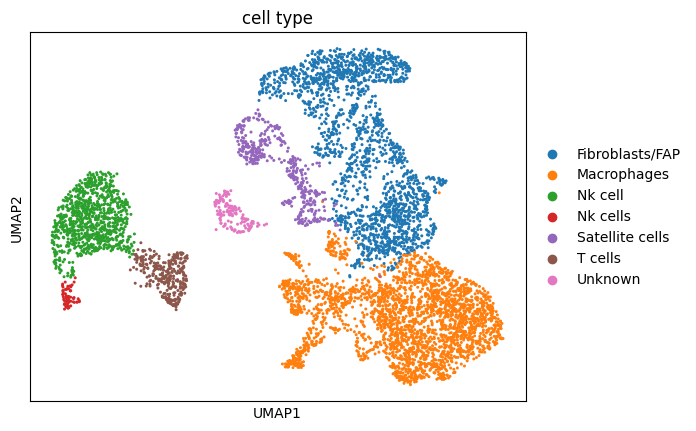

In [47]:
sc.pl.umap(adata, color = ['cell type'])  #different cell types in sample

In [48]:
satellite_cells = adata[adata.obs['cell type'] == 'Satellite cells'].copy()

In [49]:
scamp_genes = ['Scamp1', 'Scamp2', 'Scamp3', 'Scamp4', 'Scamp5']

In [50]:
sat_scamp_expr = satellite_cells[:, scamp_genes]

In [51]:
satellite_cells.var[satellite_cells.var_names.isin(scamp_genes)]

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Scamp3  False               2019     0.467217              68.556300   
Scamp5  False                441     0.089238              93.131911   
Scamp2  False               2752     0.844105              57.140632   
Scamp4  False                  1     0.000156              99.984426   
Scamp1  False                731     0.130976              88.615480   

        total_counts  highly_variable     means  dispersions  \
Scamp3        3000.0             True  0.365231     0.898904   
Scamp5         573.0             True  0.081222     1.059858   
Scamp2        5420.0             True  0.602205     1.076432   
Scamp4           1.0             True  0.000333     0.760142   
Scamp1         841.0             True  0.128063     1.177673   

        dispersions_norm          mean       std  
Scamp3         -1.156033 -5.900873e-17  0.409029  
Scamp5          0.076112 -9.696271e-18  0.203036  
Scamp2         -0.826144  0.000000e+00  0.532355  
Scamp4         -0.261478 -6.925908e-20  0.014283  
Scamp1          0.208815 -2.036217e-17  0.251979

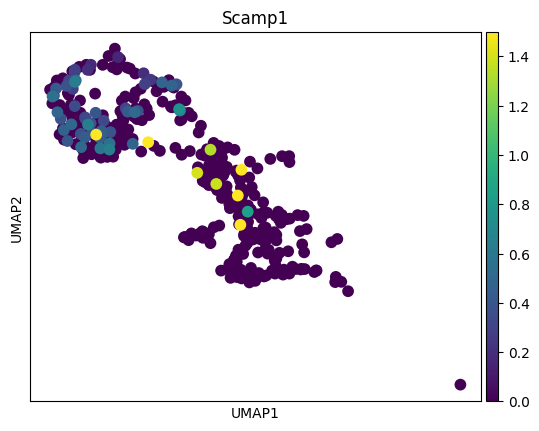

In [65]:
sc.pl.umap(satellite_cells, color = 'Scamp1', vmin = 0.0, vmax = 1.5)

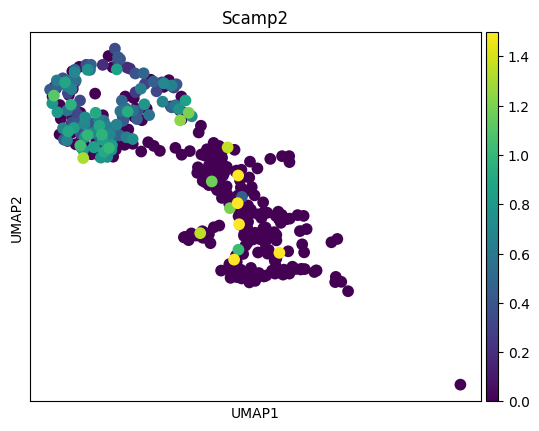

In [66]:
sc.pl.umap(satellite_cells, color = 'Scamp2', vmin = 0.0, vmax = 1.5)

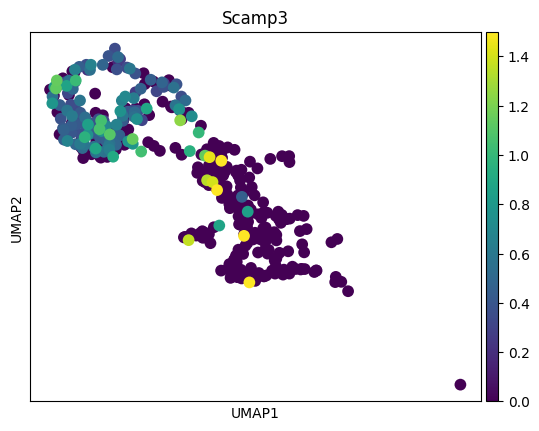

In [67]:
sc.pl.umap(satellite_cells, color = 'Scamp3', vmin = 0.0, vmax = 1.5)

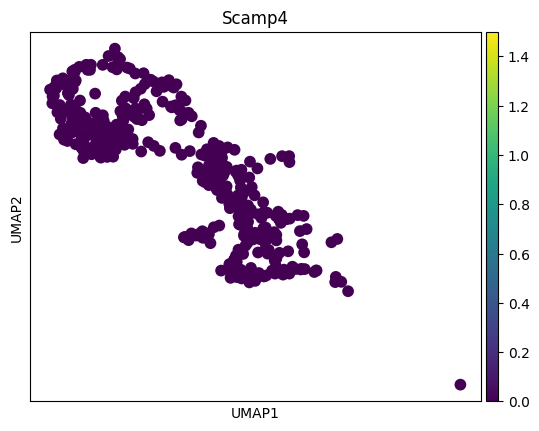

In [68]:
sc.pl.umap(satellite_cells, color = 'Scamp4', vmin = 0.0, vmax = 1.5)

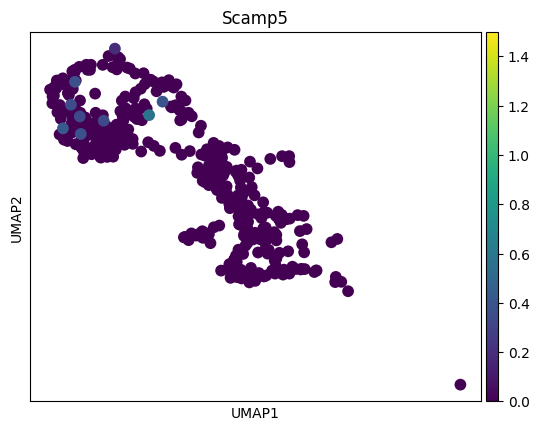

In [69]:
sc.pl.umap(satellite_cells, color = 'Scamp5', vmin = 0.0, vmax = 1.5)

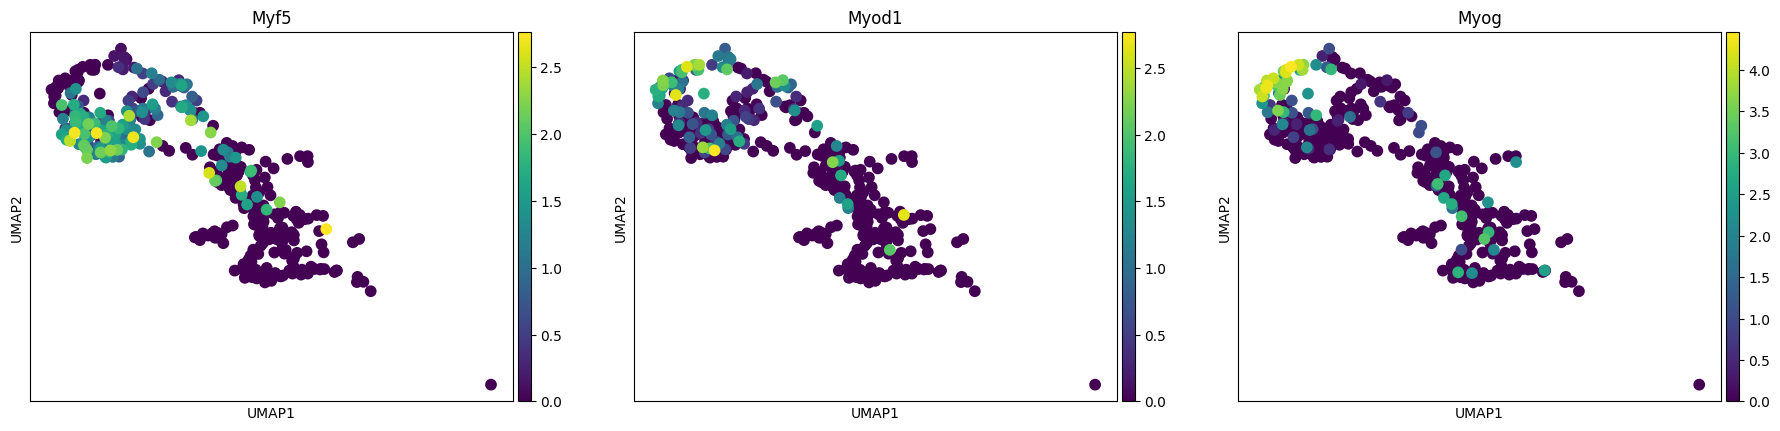

In [64]:
sc.pl.umap(satellite_cells, color = ['Myf5', 'Myod1', 'Myog'])

(0.0, 1.7)

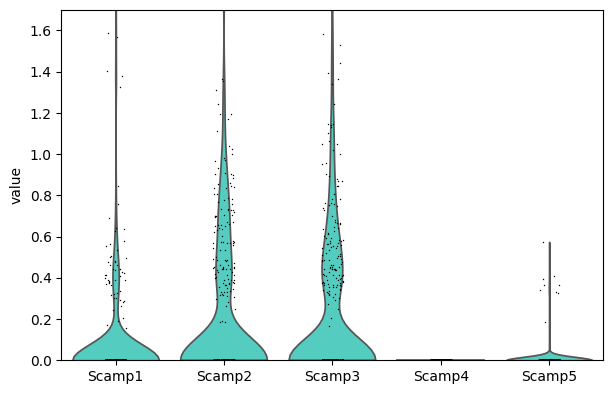

In [54]:
violinax = sc.pl.violin(satellite_cells, scamp_genes, color = '#40e0d0', show = False)
plt.ylim(0.0, 1.7)
#figure 1 b

In [55]:
sat_scamp_expr.X.sum(axis = 0)

array([ 22.01079697, -32.21179262,  30.49857929,   2.93322439,
       -56.9549352 ])

In [56]:
#get a list of observation names from satellite cells adata object
satellite_obs = list(satellite_cells.obs_names)

#reread in the original adata object 
reread_adata = sc.read_h5ad('/Users/danielpintard/Documents/Code/Bioinformatics/scRNAseq-SCAMPs/data/doublet_filtered/old_filtered_adata.h5ad')

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [57]:
#create a new column in observations of reread adata indicating which cell are sattelite cells 
#probably something along the lines of:
# if obs in satellite cell names, then assign true in reread adata object

satellite_cell_values = np.where(reread_adata.obs_names.isin(satellite_obs), True, False)
reread_adata.obs['satellite_cell'] = satellite_cell_values

In [58]:
#this way I will have the raw, non normalized, non processed counts of genes in the satellite cell population
raw_satcell_adata = reread_adata[reread_adata.obs['satellite_cell'] == True]
#then what I will do is get rid of all of the variables other than scamp genes 
#quantify their counts and then use that to get relative gene expression compared to all the other cells

In [59]:
raw_satcell_scamp = raw_satcell_adata[:, raw_satcell_adata.var_names.isin(scamp_genes)] #this boolean masking thing is really cool, just learnt it today (4/11)

In [60]:
raw_satcell_scamp.X.sum(axis = 0)

matrix([[226.,  10., 226.,   0.,  66.]], dtype=float32)

In [61]:
raw_satcell_adata

View of AnnData object with n_obs × n_vars = 419 × 32285
    obs: 'doublet', 'satellite_cell'

In [64]:
#raw_satcell_scamp.write('old_satcell_scamp.h5ad')
# already saved to data/satellite_cell_adata directory